In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.nasnet import NASNetLarge, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define the image size
IMAGE_SIZE = [224, 224]

In [4]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [5]:
# Replace this line with the path to the downloaded NASNetLarge model weights on your local machine
weights_path = '/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Pneumonia_models/NASNet-large-no-top.h5'

# Import the NASNetLarge model
nasnet = NASNetLarge(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights=None)

# Load the downloaded weights
nasnet.load_weights(weights_path)

In [6]:
# Freeze all layers in the NASNetLarge model
for layer in nasnet.layers:
    layer.trainable = False


In [7]:
# Get the folders in the training data directory
folders = glob('chest_xray/train/*')

In [8]:
# Add a global average pooling layer and a dense layer to the NASNetLarge model
x = keras.layers.GlobalAveragePooling2D()(nasnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [9]:
# Create a model object
model = Model(inputs=nasnet.input, outputs=prediction)


In [10]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 96)         2592      ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 96)         0         ['stem_bn1[0][0]']        

In [11]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                target_size=(224, 224),
                                                batch_size=10,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=(224, 224),
                                            batch_size=10,
                                            class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
# Train the model
model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

522/522 [==============================] - 701s 1s/step - loss: 0.2160 - accuracy: 0.9034 - val_loss: 0.3242 - val_accuracy: 0.8782


In [15]:
# Load and preprocess an image for prediction
img = image.load_img('chest_xray/test/Normal/IM-0001-0001.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
result = int(classes[0][0])

if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")


1/1 [==============================] - 4s 4s/step
Person is Affected By PNEUMONIA


In [16]:
# Initialize an empty list to store true and predicted labels
true_labels = []
predicted_labels = []

In [18]:
# Loop through the test set and predict labels
for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)

    # Convert one-hot encoded labels to class labels
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 438ms/step


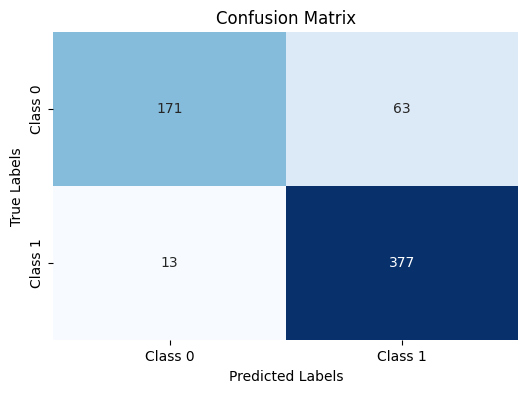

In [19]:
# Calculate the confusion matrix, accuracy, precision, recall, and F1-score
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.show()

In [20]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8782051282051282
Precision : 0.8568181818181818
Recall    : 0.9666666666666667
F1-score  : 0.908433734939759
